- Similar to abstracts_2 but using extended keyword sets.
- Probably too many generic words there, so needs to have 2 keyword matches to get labeled.

Result:
- Predicts RL a lot for unseen data. 
- Predicts almost no multilabels for unseen data.
- Predictions are almost identical to training labels for training data.

## Setup

In [3]:
# Imports

import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm
import collections

In [4]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
table_path = Path("../../reports/tables")
figure_path = Path("../../reports/figures")
keywords_path = Path("../../keywords")
processed_abstracts_path = Path("../../data/processed/abstracts")

# Ensure directories exist
for p in [data_path, table_path, figure_path, keywords_path, processed_abstracts_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [5]:
# Constants

CREATE_ABSTRACTS_DATASET = False

# Number of topics used for K-means
n_topics = 8

#### Create Abstracts dataset (only need to do this once)

In [6]:
# Helper: Clean Abstracts
# Basic text cleaning

# Light cleaning for model input: keep most of the original signal
def clean_text_for_model(text):
    if not isinstance(text, str):
        return ""

    # Remove Scopus-style copyright header at the very beginning
    text = re.sub(r"^©\s*\d{0,4}\s*the author\(s\)\s*", "", text, flags=re.IGNORECASE)

    # Optionally strip URLs and extra whitespace, but keep punctuation, numbers, etc.
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [ ]:
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(data_path.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    # Cover date was not included in last script
                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        # "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df = pd.DataFrame(records)
    
    # Remove empty abstracts early
    df = df[df["abstract"].notna() & (df["abstract"].str.strip() != "")]
    df = df.reset_index(drop=True)
    
    # Clean abstracts
    df["clean_abs"] = df["abstract"].apply(clean_text_for_model)
    
    print(f"\nCollected {len(df)} abstracts from {len(df['query_id'].unique())} queries")

    # Save for later analysis
    out_path = processed_abstracts_path / "abstracts.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")


In [8]:
# Load dataframe with abstracts
# Only if it has been created earlier

if not CREATE_ABSTRACTS_DATASET:
    abstracts_path = processed_abstracts_path / "abstracts.csv"
    df = pd.read_csv(abstracts_path) 
    print(f"Loaded {len(df)} abstracts")


Loaded 32714 abstracts


In [9]:
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S..."


## Analyze with Keywords (Supervised / Unsupervised / Reinforcement)

Each article is classified using keyword matching based on its cleaned abstract.
The classification is **multi-label**, meaning an article may be tagged as
supervised, unsupervised, and/or reinforcement learning depending on which
keywords appear as whole words in the text.

In [10]:
# Gather all extended keywords 

def load_keyword_file(path: Path) -> list[str]:
    keywords = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            keywords.append(line.lower())
    return keywords


def load_all_keywords(base_dir: Path = keywords_path) -> dict[str, list[str]]:
    return {
        "supervised": load_keyword_file(base_dir / "supervised_ext.txt"),
        "unsupervised": load_keyword_file(base_dir / "unsupervised_ext.txt"),
        "reinforcement": load_keyword_file(base_dir / "reinforcement_ext.txt"),
    }


ml_keywords = load_all_keywords()


In [37]:
# For each ML category, create a binary column (1/0) indicating
# whether any of that category's keywords appear in the cleaned abstract.
# (Uses word-boundary matching so e.g. 'supervised' does NOT match inside 'unsupervised')

def contains_keyword(text, keyword):
    # Escape keyword and enforce word boundaries (\b)
    pattern = rf"\b{re.escape(keyword)}\b"
    return re.search(pattern, text) is not None

# Keyword labeling: require at least 2 keyword matches per category
def count_keywords(text, keywords):
    text = (text or "").lower()
    return sum(1 for kw in keywords if contains_keyword(text, kw))

for label in ml_keywords.keys():
    df[f"is_{label}"] = df["clean_abs"].apply(
        lambda t, lab=label: 1 if count_keywords(t, ml_keywords[lab]) >= 2 else 0
    )

    
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...,1,1,0,1,1,0
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",0,0,0,1,1,1


In [38]:
# Create a column: "ml_type" that lists all categories with True

def resolve_label(row):
    labels = []
    if row["is_supervised"]: labels.append("supervised")
    if row["is_unsupervised"]: labels.append("unsupervised")
    if row["is_reinforcement"]: labels.append("reinforcement")
    return labels or ["unknown"]

df["ml_type"] = df.apply(resolve_label, axis=1)

df.head()


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement,ml_type
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...,1,1,0,1,1,0,"[supervised, unsupervised]"
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",0,0,0,1,1,1,[unknown]
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",1,0,0,1,1,0,[supervised]
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,2025.The critical necessity for sophisticated ...,1,0,0,1,1,1,[supervised]
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...,0,0,0,0,1,1,[unknown]


In [40]:
# Frequency of each ML category
df["ml_type"].explode().value_counts()

ml_type
unknown          17980
supervised       12365
reinforcement     2282
unsupervised      1829
Name: count, dtype: int64

In [73]:
# Show some examples with only unsupervised keyword label
mask_only_unsup = (
    (df["is_unsupervised"] == 1) &
    (df["is_supervised"] == 0) &
    (df["is_reinforcement"] == 0)
)

df_only_unsup = df[mask_only_unsup]
print("Total only unsupervised:", len(df_only_unsup), "\n")

df_only_unsup.head()


Total only unsupervised: 700 



,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
11,ml_anomaly_detection_production,2-s2.0-105012866474,10.1016/j.oceaneng.2025.122365,Scour identification around offshore wind turb...,© 2025 The AuthorsThis paper presents a novel ...,© 2025 The AuthorsThis paper presents a novel ...,0,1,0,0,1,0
12,ml_anomaly_detection_production,2-s2.0-105019525303,10.1016/j.jii.2025.100970,Distillation anomaly and fault detection based...,© 2025 The Author(s)Anomaly detection in produ...,Anomaly detection in production processes is e...,0,1,0,0,1,0
37,ml_anomaly_detection_production,2-s2.0-105008479968,10.1007/s10489-025-06603-1,Multi-block local outlier factor anomaly detec...,© The Author(s) 2025.Anomaly detection is crit...,2025.Anomaly detection is critical in industri...,0,1,0,0,1,0
42,ml_anomaly_detection_production,2-s2.0-105008358010,10.1088/1361-6633/add762,Model-agnostic search for dijet resonances wit...,Creative Commons Attribution license.This pape...,Creative Commons Attribution license.This pape...,0,1,0,1,1,0
46,ml_anomaly_detection_production,2-s2.0-105000669270,10.1016/j.apacoust.2025.110687,Enhancing quality inspection of highly variant...,© 2025 Elsevier LtdQuality inspection is an im...,© 2025 Elsevier LtdQuality inspection is an im...,0,1,0,0,1,0


In [75]:
# Show some examples with only reinforcement keyword label
mask_only_rl = (
    (df["is_reinforcement"] == 1) &
    (df["is_supervised"] == 0) &
    (df["is_unsupervised"] == 0)
)

df_only_rl = df[mask_only_rl]
print("Total only reinforcement:", len(df_only_rl), "\n")

df_only_rl.head()


Total only reinforcement: 1620 



,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
76,ml_anomaly_detection_production,2-s2.0-105019060994,10.1109/EEAIS66172.2025.11170654,AI-Driven Automation in Telecom Infrastructure...,"© 2025 IEEE.This paper presents a novel, paten...","© 2025 IEEE.This paper presents a novel, paten...",0,0,1,0,0,1
84,ml_anomaly_detection_production,2-s2.0-105017718104,10.2118/226728-MS,Offshore Production Surveillance and Intervent...,"Copyright © 2025, Society of Petroleum Enginee...","Copyright © 2025, Society of Petroleum Enginee...",0,0,1,0,0,1
131,ml_anomaly_detection_production,2-s2.0-105006979277,10.2118/225238-MS,Neuron 5 Transforming the Industry Autonomous ...,"Copyright 2025, Society of Petroleum Engineers...","Copyright 2025, Society of Petroleum Engineers...",0,0,1,0,0,1
136,ml_anomaly_detection_production,2-s2.0-105004325549,NaN,2nd International Conference on Cognitive Mobi...,The proceedings contain 34 papers. The special...,The proceedings contain 34 papers. The special...,0,0,1,0,0,1
144,ml_anomaly_detection_production,2-s2.0-105001299312,NaN,2nd European Symposium on Artificial Intellige...,The proceedings contain 29 papers. The special...,The proceedings contain 29 papers. The special...,0,0,1,0,0,1


In [42]:
# Frequency for each query
df.explode("ml_type").groupby(["query_id", "ml_type"]).size().unstack(fill_value=0)

ml_type,reinforcement,supervised,unknown,unsupervised
query_id,,,,
ml_anomaly_detection_production,48,297,291,230
ml_automation,134,362,1145,64
ml_defect_detection,18,318,331,64
ml_manufacturing_optimization,307,1163,2462,131
ml_planning_production,228,887,1178,103
ml_plm,11,69,173,6
ml_predictive_maintenance,243,2531,1675,360
ml_process_control,299,929,1991,183
ml_process_modeling,41,181,521,33


In [43]:
# Percentage of abstracts that mention each ML category
df[["is_supervised", "is_unsupervised", "is_reinforcement"]].mean()

is_supervised       0.377973
is_unsupervised     0.055909
is_reinforcement    0.069756
dtype: float64

<Axes: xlabel='ml_type'>

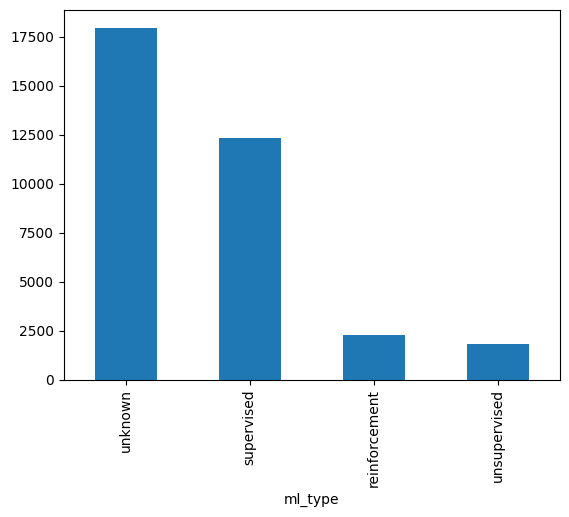

In [44]:
# Plot frequency of ML categories across all abstracts
df["ml_type"].explode().value_counts().plot(kind="bar")

In [45]:
# Sample of abstracts that were classified as "unknown"
# Should analyze to improve keyword sets
df[df["ml_type"].apply(lambda x: x == ["unknown"])].sample(2)


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement,ml_type
28483,ml_quality_control,2-s2.0-85158102179,10.1111/exsy.13319,Semantic data mining-based decision support fo...,© 2023 John Wiley & Sons Ltd.This study evalua...,© 2023 John Wiley & Sons Ltd.This study evalua...,0,0,0,1,0,0,[unknown]
23381,ml_production_optimization,2-s2.0-85199019802,10.1029/2023MS004115,Machine Learning Driven Sensitivity Analysis o...,© 2024 The Author(s). Journal of Advances in M...,. Journal of Advances in Modeling Earth System...,0,0,0,1,0,0,[unknown]


### Notes on Keyword-Based Classification

The keyword approach provides a simple first pass, but it has clear limitations:
- Many abstracts are labeled **unknown** because keywords may be absent, implicit, or expressed differently.
- Some methods overlap terminology (e.g., “semi-supervised”), which can lead to misclassification.
- Context is ignored, so the presence of a term does not guarantee it is the main ML method.

These limitations explain the large number of “unknown” cases and motivate using a more robust model-based classifier later.

## Training a Multi-Label ML-Method Classifier Using Keyword Pseudo-Labels

- The keyword-based approach provides noisy but useful initial labels for each article (e.g., supervised / unsupervised / reinforcement).  
- In the following steps, we use these pseudo-labels to train a **multi-label transformer model** (e.g., SciBERT or DistilBERT) on the abstracts. 
- This allows the model to learn richer linguistic patterns and produce more accurate classifications than the raw keyword method, while requiring **no manual labeling up front**.


In [46]:
import torch
print(torch.__version__)

2.9.1+cu128


In [47]:
from datasets import Dataset
import numpy as np

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Keep only rows that have at least one positive label (optional but often useful)
df_model = df.copy()
mask_any_label = df_model[label_cols].sum(axis=1) > 0
df_model = df_model[mask_any_label].reset_index(drop=True)

print(df_model[label_cols].mean())  # quick check of label frequencies

dataset = Dataset.from_pandas(df_model[["clean_abs"] + label_cols])

# Train/validation split
splits = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = splits["train"]
val_ds = splits["test"]



is_supervised       0.839215
is_unsupervised     0.124135
is_reinforcement    0.154880
dtype: float64


In [48]:
# Ensure scibert directory exists
scibert_path = processed_abstracts_path / "scibert_5"
scibert_path.mkdir(parents=True, exist_ok=True)

# Save datasets
train_path = scibert_path / "train_ds.csv"
val_path = scibert_path / "val_ds.csv"

train_ds.to_csv(train_path, index=False)
val_ds.to_csv(val_path, index=False)

print(f"Saved train_ds to: {train_path}")
print(f"Saved val_ds to:   {val_path}")

Creating CSV from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Creating CSV from Arrow format: 100%|██████████| 3/3 [00:00<00:00, 45.68ba/s]

Saved train_ds to: ../../data/processed/abstracts/scibert_5/train_ds.csv
Saved val_ds to:   ../../data/processed/abstracts/scibert_5/val_ds.csv


In [49]:
train_ds.to_pandas().head()


,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,© 2024 International Solar Energy SocietySolar...,1,0,0
1,© 2021 IEEE.The prediction of a Lithium-ion ba...,1,0,0
2,© 2023 Elsevier LtdPoplar trees are a renewabl...,1,0,0
3,"© 2022, Publish-Ing in cooperation with TIB - ...",0,0,1
4,© 2023 The Royal Society of Chemistry.The inna...,1,0,0


In [50]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "allenai/scibert_scivocab_uncased"  # or "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Add a single multi-label 'labels' column
def add_labels(example):
    example["labels"] = [float(example[c]) for c in label_cols]
    return example

train_ds_l = train_ds.map(add_labels)
val_ds_l   = val_ds.map(add_labels)

def tokenize_batch(batch):
    return tokenizer(
        batch["clean_abs"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )

train_ds_tok = train_ds_l.map(tokenize_batch, batched=True)
val_ds_tok   = val_ds_l.map(tokenize_batch, batched=True)

def set_format(ds):
    return ds.with_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"],
    )

train_ds_tok = set_format(train_ds_tok)
val_ds_tok   = set_format(val_ds_tok)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
)


Map: 100%|██████████| 2947/2947 [00:00<00:00, 3738.36 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
# Compute average number of tokens per abstract using the tokenizer

lengths = []

for text in df["clean_abs"].tolist():
    enc = tokenizer(
        text,
        truncation=True,
        max_length=2048,
    )
    lengths.append(len(enc["input_ids"]))

avg_len = sum(lengths) / len(lengths)
max_len = max(lengths)
min_len = min(lengths)

print(f"Average token length: {avg_len:.2f}")
print(f"Min tokens: {min_len}, Max tokens: {max_len}")


Average token length: 276.98
Min tokens: 27, Max tokens: 2048


In [52]:
# Count how many abstracts exceed various token-length thresholds

thresholds = [256, 512, 768, 1024, 1500]

lengths = []
for text in df["clean_abs"].tolist():
    enc = tokenizer(text, truncation=False)   # do NOT truncate → get true length
    lengths.append(len(enc["input_ids"]))

results = {}
for t in thresholds:
    results[t] = sum(l > t for l in lengths)

print("Token length distribution:")
for t, count in results.items():
    print(f" > {t:4d} tokens : {count} abstracts")

# Optional: also show % of dataset
n = len(lengths)
print("\nPercentages:")
for t, count in results.items():
    print(f" > {t:4d} tokens : {count/n*100:.2f}%")


Token length distribution:
 >  256 tokens : 17172 abstracts
 >  512 tokens : 922 abstracts
 >  768 tokens : 173 abstracts
 > 1024 tokens : 77 abstracts
 > 1500 tokens : 6 abstracts

Percentages:
 >  256 tokens : 52.49%
 >  512 tokens : 2.82%
 >  768 tokens : 0.53%
 > 1024 tokens : 0.24%
 > 1500 tokens : 0.02%


In [53]:
# Check cuda version etc for debugging

print(torch.version.cuda)
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())
print(torch.cuda.get_arch_list())

12.8
NVIDIA A100-SXM4-80GB
(8, 0)
['sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'sm_100', 'sm_120']


In [54]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))           # sigmoid
    preds = (probs >= 0.5).astype(int)

    # Flatten over labels
    return {
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
        "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),
    }

training_args = TrainingArguments(
    output_dir="./ml_type_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=val_ds_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipykernel_1877904/310402851.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Micro,Recall Micro
1,0.081800,0.085176,0.956287,0.910044,0.943391,0.969540
2,0.072900,0.060118,0.974785,0.951365,0.966467,0.983247
3,0.025500,0.049384,0.978511,0.961765,0.972331,0.984770


TrainOutput(global_step=2211, training_loss=0.08429373645070773, metrics={'train_runtime': 715.2742, 'train_samples_per_second': 49.437, 'train_steps_per_second': 3.091, 'total_flos': 9303953564279808.0, 'train_loss': 0.08429373645070773, 'epoch': 3.0})

In [55]:
# Tune thresholds based on validation set

logits_val, labels_val = trainer.predict(val_ds_tok)[:2]
probs_val = 1 / (1 + np.exp(-logits_val))

best_thresholds = {}

for i, col in enumerate(label_cols):
    best_f1 = 0.0
    best_t = 0.5
    for t in np.linspace(0.5, 0.9, 17):  # Try thresholds between 0.5 and 0.9
        preds = (probs_val[:, i] >= t).astype(int)
        f1 = f1_score(labels_val[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[col] = best_t

print("Best thresholds:", best_thresholds)


Best thresholds: {'is_supervised': np.float64(0.9), 'is_unsupervised': np.float64(0.6), 'is_reinforcement': np.float64(0.675)}


In [ ]:
def predict_ml_types_batched(texts, trainer, threshold=0.5, batch_size=64, max_length=512):
    all_preds = []
    all_probs = []

    model = trainer.model
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        enc = {k: v.to(model.device) for k, v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits

        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= threshold).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)

    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    return all_preds, all_probs


texts = df["clean_abs"].tolist()
preds, probs = predict_ml_types_batched(texts, trainer, batch_size=64, threshold=0.5)

for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]


In [57]:
for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]

pred_cols = [f"pred_{c}" for c in label_cols]
cols_to_save = [
    "query_id", "eid", "doi", "title", "abstract", "clean_abs",
] + label_cols + pred_cols

save_path = scibert_path / "abstracts_with_predictions.csv"
df[cols_to_save].to_csv(save_path, index=False)

print(f"Saved predictions to: {save_path}")

Saved predictions to: ../../data/processed/abstracts/scibert_5/abstracts_with_predictions.csv


## Analyze Scibert Predictions

In [58]:
pred_path = Path("../../data/processed/abstracts/scibert_5/abstracts_with_predictions.csv")

pred_cols = ["pred_is_supervised","pred_is_unsupervised","pred_is_reinforcement"]

In [59]:
df = pd.read_csv(pred_path)
df.head()

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...,1,1,0,1,1,0
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",0,0,0,1,1,0
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",1,0,0,1,0,0
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,2025.The critical necessity for sophisticated ...,1,0,0,1,0,0
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...,0,0,0,1,0,0


In [60]:
df[pred_cols].mean()

pred_is_supervised       0.673443
pred_is_unsupervised     0.080944
pred_is_reinforcement    0.279972
dtype: float64

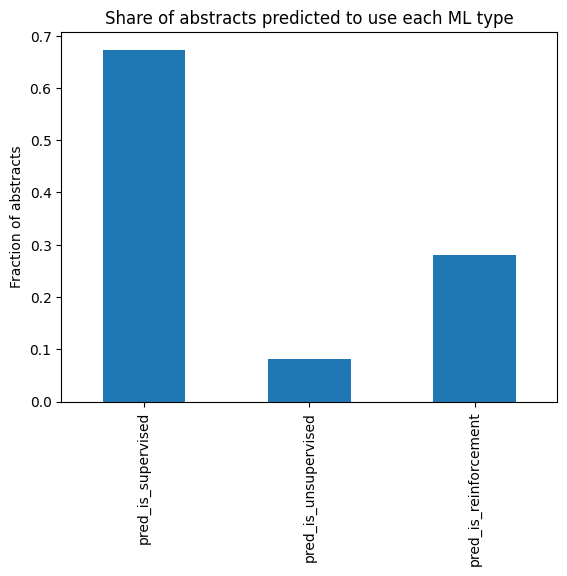

In [61]:
df[pred_cols].mean().plot(kind="bar")
plt.title("Share of abstracts predicted to use each ML type")
plt.ylabel("Fraction of abstracts")
plt.show()

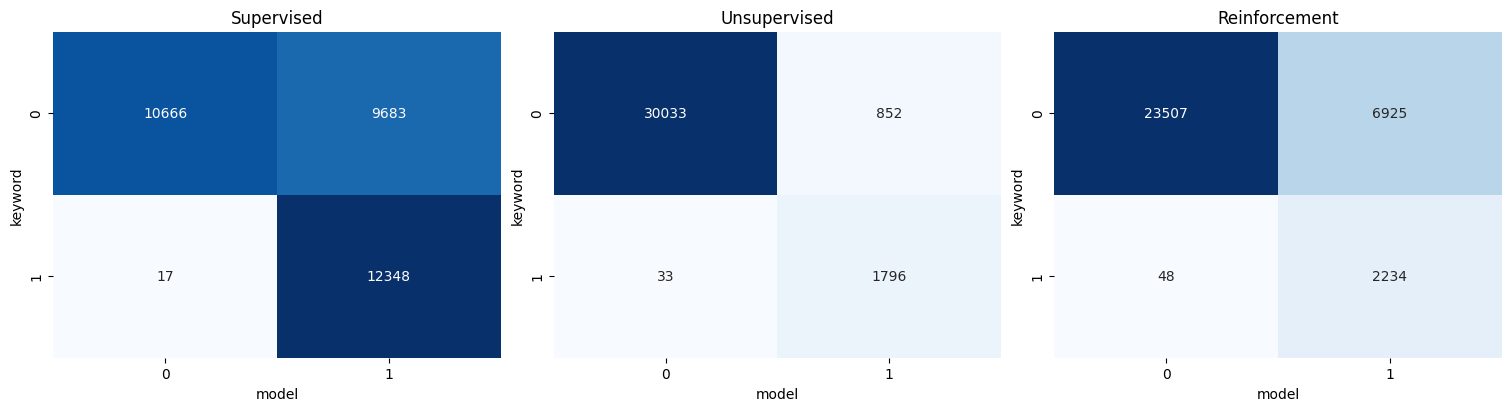

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

for ax, col in zip(axes, label_cols):
    ctab = pd.crosstab(df[col], df[f"pred_{col}"], rownames=["keyword"], colnames=["model"])
    
    sns.heatmap(
        ctab,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax
    )
    ax.set_title(col.replace("is_", "").capitalize())

plt.show()


In [63]:
# Small per-label stats
for col in label_cols:
    pred = df[f"pred_{col}"]
    true = df[col]

    tp = ((true == 1) & (pred == 1)).sum()
    fp = ((true == 0) & (pred == 1)).sum()
    fn = ((true == 1) & (pred == 0)).sum()
    tn = ((true == 0) & (pred == 0)).sum()

    print(
        f"\n=== {col} ===\n"
        f"TP: {tp}\nFP: {fp}\nFN: {fn}\nTN: {tn}\n"
        f"Precision: {tp/(tp+fp+1e-9):.3f}\n"
        f"Recall:    {tp/(tp+fn+1e-9):.3f}\n"
    )



=== is_supervised ===
TP: 12348
FP: 9683
FN: 17
TN: 10666
Precision: 0.560
Recall:    0.999


=== is_unsupervised ===
TP: 1796
FP: 852
FN: 33
TN: 30033
Precision: 0.678
Recall:    0.982


=== is_reinforcement ===
TP: 2234
FP: 6925
FN: 48
TN: 23507
Precision: 0.244
Recall:    0.979



In [64]:
# Extract a few rows where the model disagrees with keyword labels (only among keyword-labeled rows)

mask_labeled = df[label_cols].sum(axis=1) > 0
mask_disagree = (df[[f"pred_{c}" for c in label_cols]].values != df[label_cols].values).any(axis=1)

df_mismatch = df[mask_labeled & mask_disagree]

df_mismatch.sample(10)[
    ["doi", "title", "clean_abs"] 
    + label_cols 
    + [f"pred_{c}" for c in label_cols]
]


,doi,title,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
204,10.1007/978-3-031-78266-4_7,Failure Modeling of Industrial Electric Motors...,", under exclusive license to Springer Nature S...",0,1,0,1,1,0
29459,10.1109/JIOT.2024.3516729,A Robotic AI Algorithm for Fusing Generative L...,© 2014 IEEE.Robot perception difficulties in c...,1,0,0,1,0,1
15282,10.1007/s40194-023-01519-1,A machine learning approach for efficient and ...,"© 2023, International Institute of Welding.The...",1,0,0,1,1,0
24535,10.2174/0122103155302871240527094915,Revolutionizing Plant Tissue Culture: Harnessi...,© 2024 Bentham Science Publishers.Plant tissue...,0,0,1,1,0,1
7998,10.14445/23488549/IJECE-V10I7P104,Forecasting the Factors Responsible for Improv...,© 2023 Seventh Sense Research Group®.Sugarcane...,0,1,0,1,1,0
31426,10.1109/ICSTCEE54422.2021.9708591,A hybrid approach estimates the real-time heal...,© 2021 IEEE.For Remaining useful life (RUL) pr...,1,0,1,1,1,1
30622,10.1002/qre.3525,Reliability modeling of systems with random fa...,© 2024 John Wiley & Sons Ltd.Modeling and eval...,0,1,0,1,1,0
17104,10.1021/ie990144q,Combining conceptual clustering and principal ...,Multivariate statistics and unsupervised machi...,0,1,1,0,1,0
2702,10.1080/00207543.2024.2316279,Few-shot learning for defect detection in manu...,". Published by Informa UK Limited, trading as ...",1,0,0,1,1,0
18798,10.1109/ISPCEM64498.2024.00115,Research on human-computer interaction persona...,©2024 IEEE.In order to study the role of user ...,0,0,1,0,0,0


In [65]:
# Compare prediction counts for rows used in training vs rows not used in training

# Identify which rows were used for training (those with at least one keyword-label = 1)
mask_train = df[label_cols].sum(axis=1) > 0
mask_not_train = ~mask_train

# Count predicted positives per class for train rows
pred_cols = [f"pred_{c}" for c in label_cols]

pred_counts_train = df[mask_train][pred_cols].sum()
pred_counts_not_train = df[mask_not_train][pred_cols].sum()

print("=== Predictions on TRAINED rows ===")
print(pred_counts_train)
print("\n=== Predictions on NON-TRAINED rows ===")
print(pred_counts_not_train)


=== Predictions on TRAINED rows ===
pred_is_supervised       12446
pred_is_unsupervised      1862
pred_is_reinforcement     2264
dtype: int64

=== Predictions on NON-TRAINED rows ===
pred_is_supervised       9585
pred_is_unsupervised      786
pred_is_reinforcement    6895
dtype: int64


In [ ]:
# Rows not in training and predicted ONLY reinforcement learning
mask_only_rl_pred = (
    mask_not_train &
    (df["pred_is_reinforcement"] == 1) &
    (df["pred_is_supervised"] == 0) &
    (df["pred_is_unsupervised"] == 0)
)

df_only_rl_pred = df[mask_only_rl_pred]

print("Total non-trained rows predicted ONLY RL:", len(df_only_rl_pred), "\n")
df_only_rl_pred.head(10)


Total non-trained rows predicted ONLY RL: 6702 



,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
17,ml_anomaly_detection_production,2-s2.0-105008069752,10.1007/s10586-024-05001-5,Revolutionizing electric robot charging infras...,"© The Author(s), under exclusive licence to Sp...",", under exclusive licence to Springer Science+...",0,0,0,0,0,1
51,ml_anomaly_detection_production,2-s2.0-105003383541,10.3390/jmmp9040133,Recent Advances in In Situ 3D Surface Topograp...,© 2025 by the authors.Additive manufacturing (...,© 2025 by the authors.Additive manufacturing (...,0,0,0,0,0,1
58,ml_anomaly_detection_production,2-s2.0-105000967139,10.3390/app15063337,AI-Driven Predictive Maintenance in Mining: A ...,© 2025 by the authors.The mining industry face...,© 2025 by the authors.The mining industry face...,0,0,0,0,0,1
71,ml_anomaly_detection_production,2-s2.0-85214570656,10.1016/bs.mim.2024.12.004,The role of AI in microbial fermentation: Tran...,© 2025 Elsevier LtdThe integration of artifici...,© 2025 Elsevier LtdThe integration of artifici...,0,0,0,0,0,1
74,ml_anomaly_detection_production,2-s2.0-85207869042,10.1007/978-981-97-7494-4_7,Deep Learning Approach Towards Green IIOT,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",0,0,0,0,0,1
92,ml_anomaly_detection_production,2-s2.0-105016316160,10.1109/ICOCT64433.2025.11118806,Automating Machine Learning Performance Monito...,© 2025 IEEE.The data analytics takes front row...,© 2025 IEEE.The data analytics takes front row...,0,0,0,0,0,1
117,ml_anomaly_detection_production,2-s2.0-105009408023,10.1016/j.procir.2025.03.046,Real-time process monitoring in additive manuf...,© 2025 Elsevier B.V.. All rights reserved.Addi...,© 2025 Elsevier B.V.. All rights reserved.Addi...,0,0,0,0,0,1
143,ml_anomaly_detection_production,2-s2.0-105001312160,10.1002/9781394242399.ch16,Quantum Machine Learning for Industry 4.0,© 2025 Scrivener Publishing LLC.The convergenc...,© 2025 Scrivener Publishing LLC.The convergenc...,0,0,0,0,0,1
156,ml_anomaly_detection_production,2-s2.0-85210266191,10.3390/pr12112478,A Review of Data-Driven Intelligent Monitoring...,© 2024 by the authors.The exploration and deve...,© 2024 by the authors.The exploration and deve...,0,0,0,0,0,1
169,ml_anomaly_detection_production,2-s2.0-85204502441,10.4018/979-8-3693-4240-4.ch012,Biosensor-based drones anomaly detection integ...,"© 2024, IGI Global. All rights reserved.Recent...","© 2024, IGI Global. All rights reserved.Recent...",0,0,0,0,0,1


In [80]:
# Number of predicted labels per row
pred_sum = df.loc[mask_not_train, pred_cols].sum(axis=1)

# Multilabeled = predicted 2 or 3 labels
n_multi = (pred_sum >= 2).sum()
n_total_not_train = mask_not_train.sum()

print("Total non-trained rows:", n_total_not_train)
print("Multilabeled predictions:", n_multi)
print("Share multilabeled:", round(n_multi / n_total_not_train, 3))

Total non-trained rows: 17980
Multilabeled predictions: 321
Share multilabeled: 0.018
